<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_6_Introduction_%C3%A0_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Préparation
---

Pensez à utiliser un GPU pour ce notebook !

In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Clone le projet GitHub
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --single-branch

    # Installe les packages via pip
    !pip install -r "droneRL-workshop/colab-requirements.txt"

    # Redémarre le Runtime pour utiliser les packages mis à jours
    import os
    os.kill(os.getpid(), 9)

    # Le Runtime va redémarrer après cette étape - c'est normal !

In [ ]:
%cd droneRL-workshop

/content/droneRL-workshop


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

Imports
---

In [ ]:
from env.env import DeliveryDrones
from env.wrappers import CompassQTable, LidarCompassQTable, LidarCompassChargeQTable, WindowedGridView
from agents.random import RandomAgent
from agents.qlearning import QLearningAgent
from agents.dqn import DQNAgent, DenseQNetworkFactory, ConvQNetworkFactory
from helpers.rl_helpers import MultiAgentTrainer, plot_rolling_rewards, test_agents, plot_cumulative_rewards, render_video, set_seed, ColabVideo

Introdution à Q-Learning (compass Q-table)
---

Observation space: Discrete(8)
Initial state: {0: '↘', 1: '→', 2: '←'}


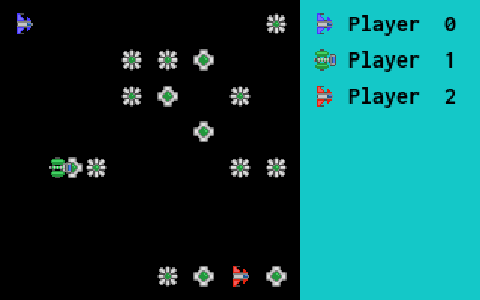

In [ ]:
# On utilise le wrapper simple CompassQTable
env = CompassQTable(DeliveryDrones())

# Environnement sans gratte-ciels, ni décharge
env.env_params.update({
    'n_drones': 3,
    'skyscrapers_factor': 0,
    'stations_factor': 0,
    'discharge': 0,
    'rgb_render_rescale': 1.5,
    })

states = env.reset()

print('Observation space:', env.observation_space)
print('Initial state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
# On crée les agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env,
    gamma=0.95, # Discount factor
    alpha=0.1, # Learning rate
    # Exploration rate
    epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01
)
agents

{0: <agents.qlearning.QLearningAgent at 0x7ea5a4091930>,
 1: <agents.random.RandomAgent at 0x7ea5a40928c0>,
 2: <agents.random.RandomAgent at 0x7ea5a40922c0>}

In [ ]:
# Entrainement
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(5000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
Training agents: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 1949.06it/s]


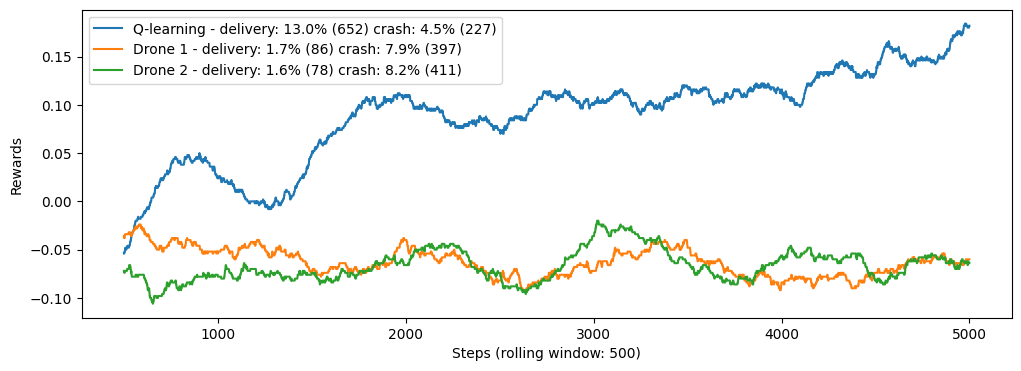

In [ ]:
plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'Q-learning'})

In [ ]:
agents[0].get_qtable()

,←,↓,→,↑,X
→,1.8,1.4,2.6,1.4,2
↙,1.5,2.5,1.2,0.73,1.3
←,2.9,1.9,1.3,1.3,2.2
↓,1.5,3.2,0.93,0.96,1.8
↖,1.5,0.92,1.2,2.4,1.4
↑,1.1,1.3,1.3,3,1.9
↗,0.68,0.91,2.1,1,1.2
↘,1.2,1.6,2.6,1.5,1.5


  and should_run_async(code)



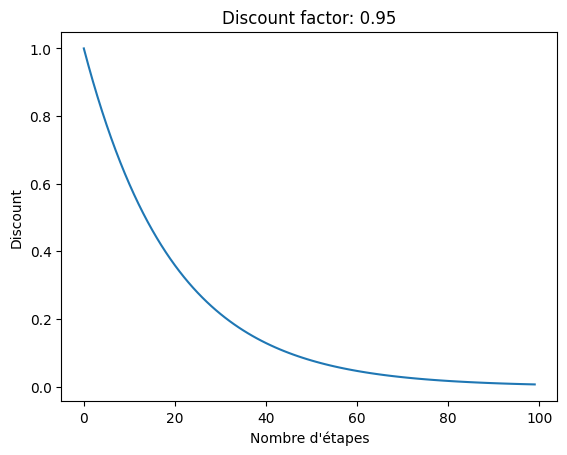

In [ ]:
plt.plot(agents[0].gamma**np.arange(100))
plt.title('Discount factor: {}'.format(agents[0].gamma))
plt.xlabel('Nombre d\'étapes')
plt.ylabel('Discount')
plt.show()

/usr/local/lib/python3.10/dist-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1752.20it/s]


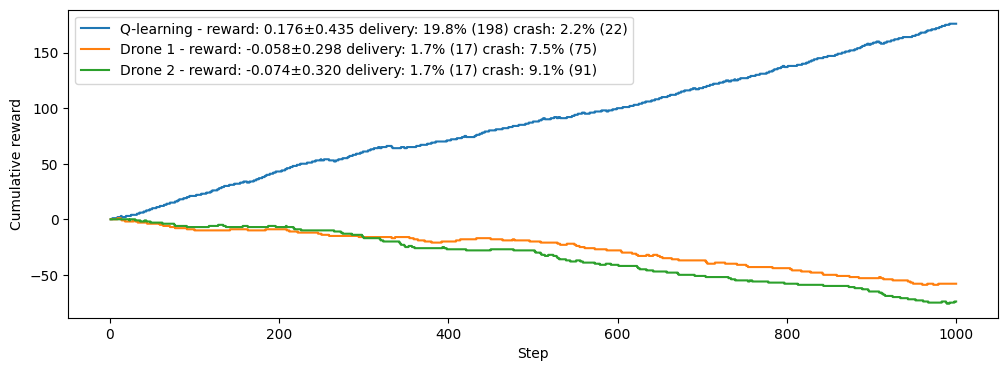

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'Q-learning'})

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

  from scipy.ndimage.filters import sobel

  deprecation(

t:   0%|                                                | 3/2880 [00:00<01:42, 28.05it/s, now=None]

Moviepy - Building video output/videos/ql-compass.mp4.
Moviepy - Writing video output/videos/ql-compass.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass.mp4


Allons plus loin : Q-table avec Compass et LIDAR
---

Ajoutons à présent des gratte-ciels (skyscrappers), toujours sans décharge, mais avec un détecteur de proximité (LIDAR).

  and should_run_async(code)



Observation space: Dict(target_dir:Discrete(8), lidar:MultiBinary(8))
Sample state: {0: 'target: ↑, lidar: ↓, →', 1: 'target: ↓, lidar: ↑', 2: 'target: ↗, lidar: →, ↖'}


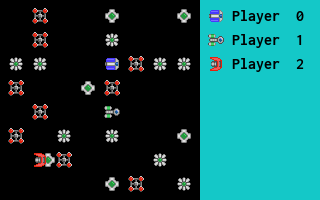

In [ ]:
env = LidarCompassQTable(DeliveryDrones())
env.env_params.update({'n_drones': 3, 'skyscrapers_factor': 3, 'stations_factor': 0, 'discharge': 0})
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', {drone_index: env.format_state(state) for drone_index, state in states.items()})
Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env,
    gamma=0.95, # Discount factor
    alpha=0.1, # Learning rate
    # Exploration rate
    epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01
)
agents

{0: <agents.qlearning.QLearningAgent at 0x7ea5a91ae6b0>,
 1: <agents.random.RandomAgent at 0x7ea5a91adf60>,
 2: <agents.random.RandomAgent at 0x7ea5a91ae080>}

Training agents: 100%|███████████████████████████████████████| 5000/5000 [00:03<00:00, 1408.52it/s]


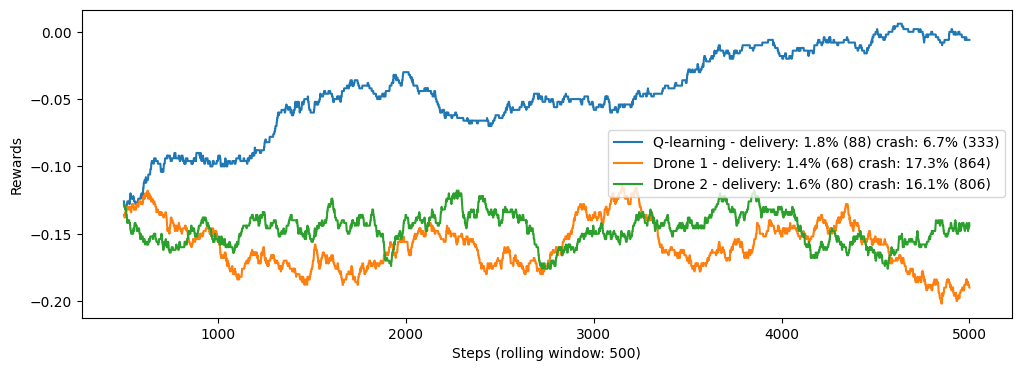

In [ ]:
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(5000)
plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'Q-learning'})

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1409.27it/s]


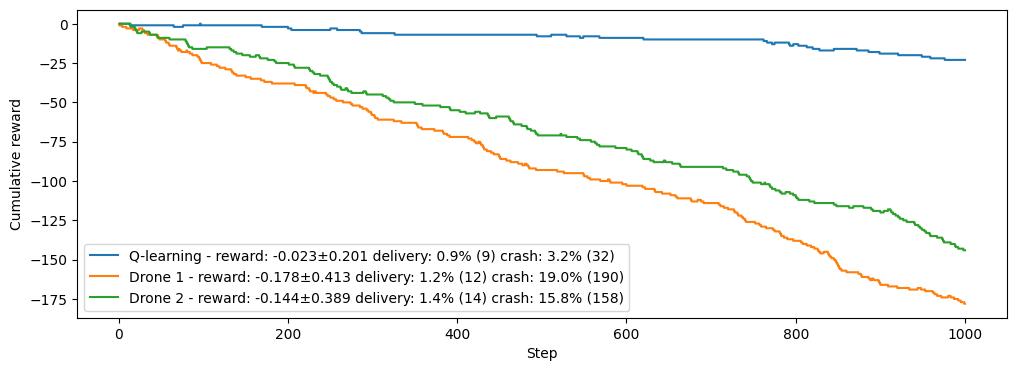

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'Q-learning'})

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-1st-try.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   2%|▉                                             | 56/2880 [00:00<00:05, 557.25it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-1st-try.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-1st-try.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-1st-try.mp4


Problèmes avec le Q-learning
---

Nous observons deux problèmes :

* Les récompenses sont rares: moins de 1% de "delivery"
* Pas de généralisation : il faut explorer toutes les solutions possibles !

In [ ]:
q_table = agents[0].get_qtable()
print('Q-table:', q_table.shape)
q_table.sample(10)

Q-table: (484, 5)


,←,↓,→,↑,X
"target: ↑, lidar: ↓, ↘, ↖",0.64,0.9,0.41,0.63,0.69
"target: ←, lidar: ↗, ↑, ↖",0.5,0.67,0.23,0.041,0.33
"target: ↖, lidar: ↙, ↓, ↘, →, ↑, ↖",0.79,0.69,0.62,0.073,0.69
"target: ↑, lidar: ←, ↙, ↖",-0.22,0.68,0.66,1.1,0.69
"target: →, lidar: ↙, ↘, →, ↑",0.88,0.11,0.47,0.049,0.96
"target: ↗, lidar: ↙, →, ↑",0.72,0.75,0.75,0.076,0.63
"target: ↖, lidar: ↓, ↘, →, ↗",0.58,-0.19,0.13,0.69,0.67
"target: →, lidar: ↙, ↓, ↘, ↗",0.82,0.11,0.11,0.81,0.29
"target: ↙, lidar: ↙",0.33,0.067,0.2,0.71,0.38
"target: →, lidar: ↘, →, ↗",0.81,0.12,0.22,0.36,0.21


Solutions possibles
---

  and should_run_async(code)

  deprecation(

Training agents: 100%|█████████████████████████████████████| 30000/30000 [00:22<00:00, 1354.85it/s]


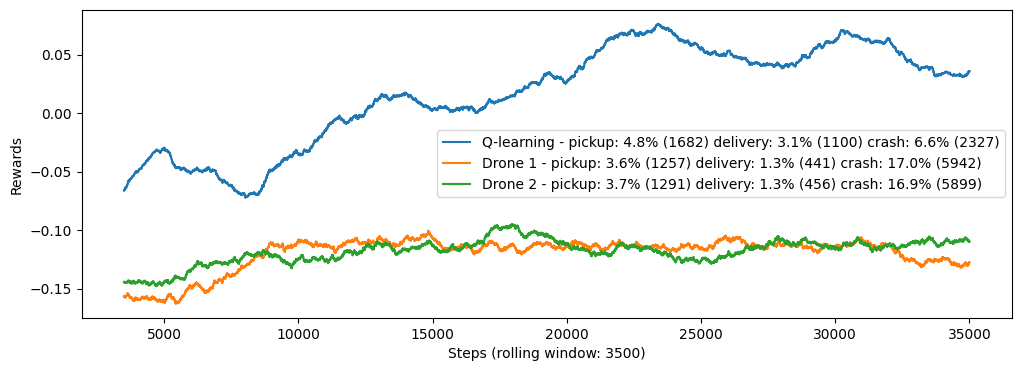

In [ ]:
# (1/2) Créer des récompenses intermédiaires : pickup_reward
env.env_params.update({
    'n_drones': 3, 'pickup_reward': 0.99, 'delivery_reward': 1,
    'skyscrapers_factor': 3, 'stations_factor': 0, 'discharge': 0})
states = env.reset()

# (2/2) Entrainer plus longtemps... ..
agents[0].epsilon = 1
agents[0].epsilon_decay = 0.999

set_seed(env, seed=0)
trainer.train(30000)

plot_rolling_rewards(
    trainer.rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'})

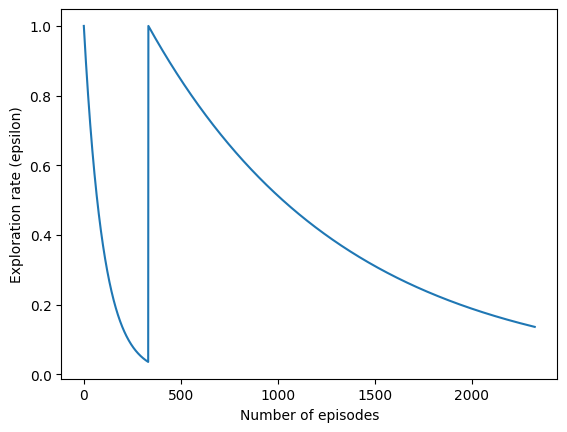

In [ ]:
plt.plot(agents[0].epsilons)
plt.xlabel('Number of episodes')
plt.ylabel('Exploration rate (epsilon)')
plt.show()

Testing agents: 100%|█████████████████████████████████████████| 1000/1000 [00:01<00:00, 971.63it/s]


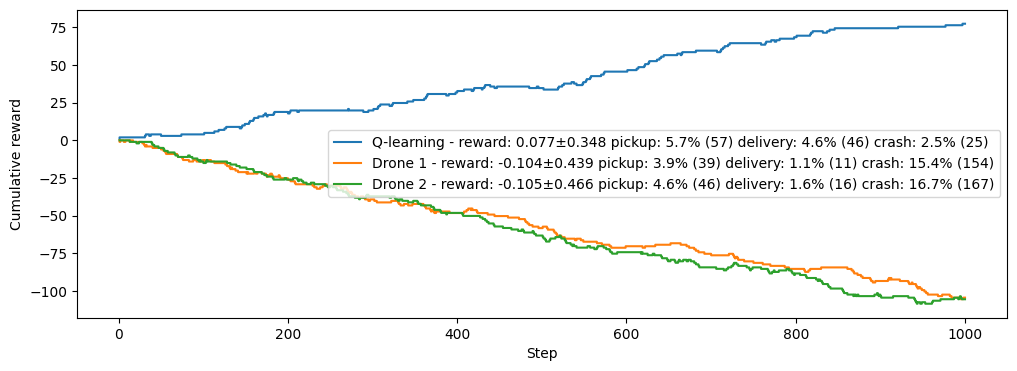

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'}
)

Risque de sur-entrainement ("overfitting")
---

Pour l'instant, on entraine notre agent que dans un seul environnement. Que ce passe-t-il si on le change ?

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1058.14it/s]


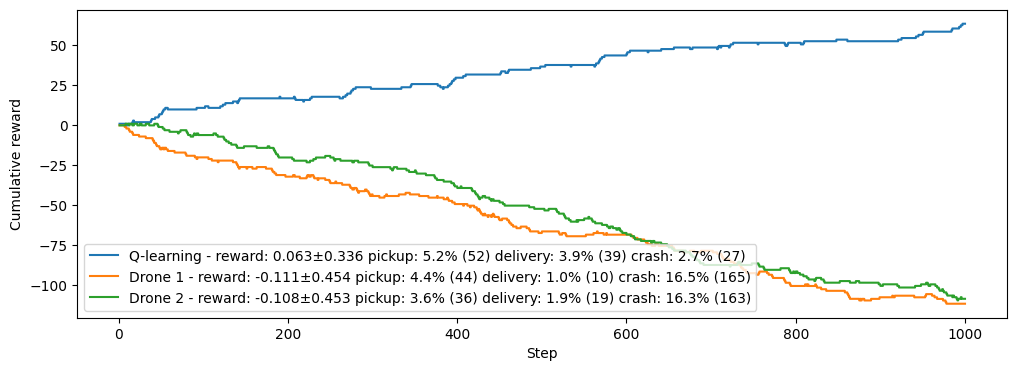

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=1)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1]},
    drones_labels={0: 'Q-learning'}
)

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-2nd-try.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=1)
ColabVideo(path)

t:   2%|▊                                             | 53/2880 [00:00<00:05, 526.17it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-2nd-try.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-2nd-try.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-2nd-try.mp4


# Exercice : Entrainez le meilleur agent possible dans cet environnement !

- Validez que votre agent est robuste en l'évaluant dans plusieurs environnements
- Comparez la performance en l'entrainant plus ou moins
- Modifier les différents paramètres : learning rate, discount factor...

Limitation du Q-learning: la taille de la Q-table!
---

Essayons maintenant avec l'environnment complet : avec gratte-ciels et décharge

Observation space: Dict(target_dir:Discrete(8), station_dir:Discrete(9), charge_level:Discrete(4), lidar:MultiBinary(8))
Sample state: target: ↗, lidar: ↘, station: ↙, charge: 3


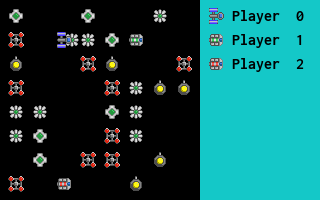

In [ ]:
env = LidarCompassChargeQTable(DeliveryDrones())
env.env_params.update({
    'n_drones': 3, 'pickup_reward': 0.99, 'delivery_reward': 1,
    'discharge': 10, 'charge': 20, 'charge_reward': -0.1  # (default values)
})
states = env.reset()

print('Observation space:', env.observation_space)
print('Sample state:', env.format_state(states[0]))
Image.fromarray(env.render(mode='rgb_array'))

Training agents: 100%|██████████████████████████████████████| 35000/35000 [00:36<00:00, 955.20it/s]


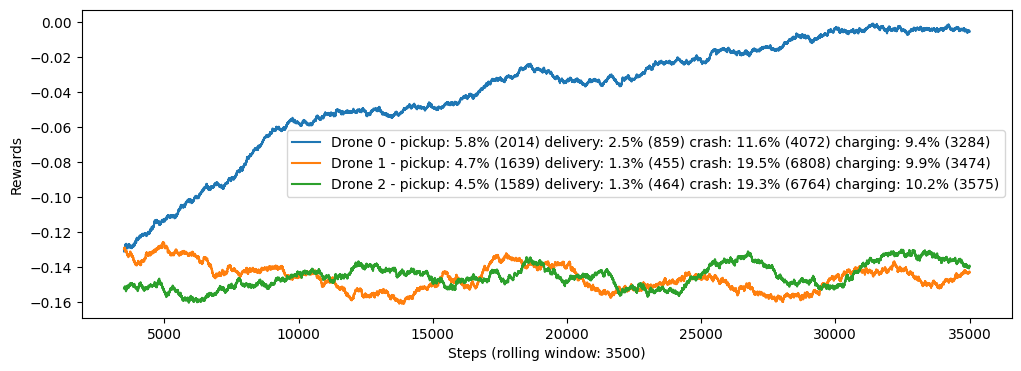

In [ ]:
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents[0] = QLearningAgent(
    env, gamma=0.95, alpha=0.1,
    epsilon_start=1, epsilon_decay=0.999, epsilon_end=0.01
)

trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)
trainer.train(35000)
plot_rolling_rewards(trainer.rewards_log, events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]})

In [ ]:
q_table = agents[0].get_qtable()
print('Q-table:', q_table.shape)
q_table.sample(10)

Q-table: (4751, 5)


,←,↓,→,↑,X
"target: ↖, lidar: ←, station: ↗, charge: 1",0.15,0.91,0.28,0.88,0.92
"target: →, lidar: ↙, ↘, station: ↗, charge: 0",0.46,0.83,0.16,0.61,0.45
"target: ↖, lidar: ↙, ↓, ↘, ↑, ↖, station: ↑, charge: 2",0.3,0.73,0.84,0.82,0.44
"target: ↓, lidar: →, station: ↘, charge: 3",0.63,0.011,0.74,0.32,0.55
"target: ↙, lidar: ↘, ↑, station: X, charge: 2",0.91,0.33,0.51,0.47,0.37
"target: ↘, lidar: ↓, station: ↗, charge: 1",0.65,0.51,0.098,0.3,0.22
"target: ↗, lidar: ←, →, station: X, charge: 3",0.26,0.018,0.92,0.74,0.62
"target: →, lidar: ↘, station: ↘, charge: 2",0.37,0.21,0.66,0.3,0.46
"target: →, lidar: ←, ↙, ↓, ↘, ↗, ↖, station: ↗, charge: 3",0.65,0.042,0.69,0.13,0.91
"target: ↗, lidar: ↖, station: ↘, charge: 0",0.16,0.92,0.83,0.73,0.5


  and should_run_async(code)

  deprecation(

Testing agents: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 1100.91it/s]


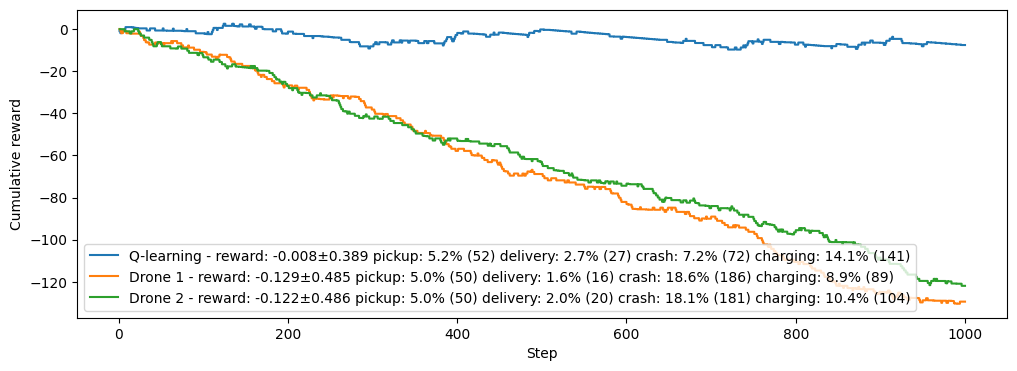

In [ ]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [0.99], 'delivery': [1], 'crash': [-1], 'charging': [-0.1]},
    drones_labels={0: 'Q-learning'}
)

In [ ]:
path = os.path.join('output', 'videos', 'ql-compass-lidar-charge.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=0)
ColabVideo(path)

t:   2%|▉                                             | 57/2880 [00:00<00:05, 561.97it/s, now=None]

Moviepy - Building video output/videos/ql-compass-lidar-charge.mp4.
Moviepy - Writing video output/videos/ql-compass-lidar-charge.mp4



Moviepy - Done !
Moviepy - video ready output/videos/ql-compass-lidar-charge.mp4


# Pouvez-vous faire mieux ? 💪